🔧 CONFIGURATION / CONFIGURACIÓN
✅ ENGLISH: Current directory / Directorio actual: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks
✅ ENGLISH: Figures will be saved in / Figuras se guardarán en: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\figures
✅ ESPAÑOL: Resultados se guardarán en / Results will be saved in: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\resultados
✅ ENGLISH: Using device / Usando dispositivo: cpu

📂 ENGLISH: Loading M5 dataset...
📂 ESPAÑOL: Cargando dataset M5...
✅ ENGLISH: Dataset found / Dataset encontrado: ../data/processed/m5_top3_multivariate.csv
✅ ENGLISH: Dataset shape / Dimensiones: (1458, 14)
✅ ESPAÑOL: Productos / Products: ['FOODS_3_090_CA_3_validation', 'FOODS_3_586_TX_2_validation', 'FOODS_3_586_TX_3_validation']

🎯 ENGLISH: Selecting top product...
🎯 ESPAÑOL: Seleccionando producto top...
✅ ENGLISH: Product selected / Producto seleccionado: FOODS_3_090_C

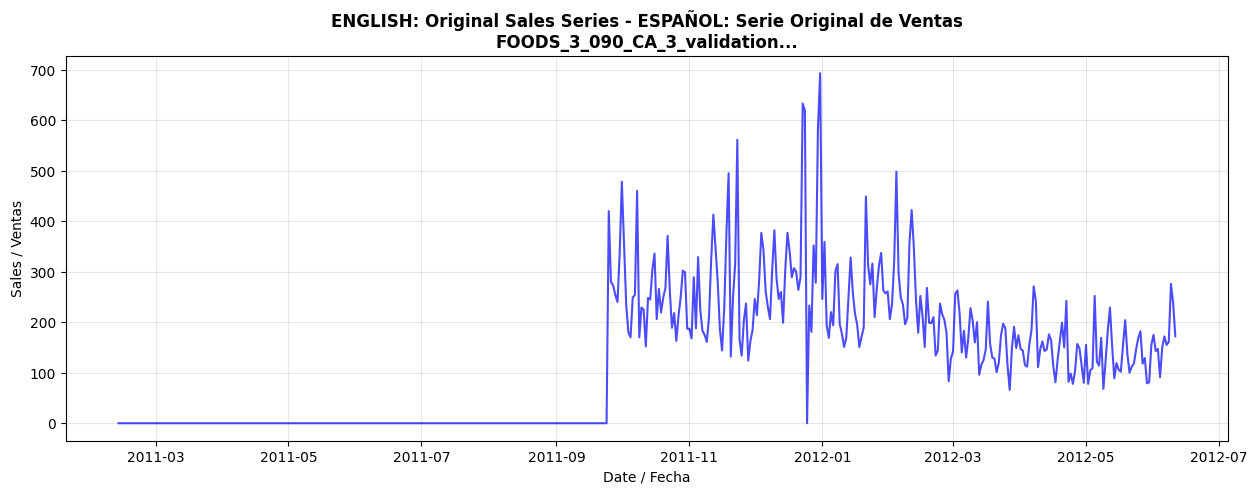


🧹 ENGLISH: Defining Denoising Autoencoder (Improved)...
🧹 ESPAÑOL: Definiendo Autoencoder Denoising (Mejorado)...

🔧 ENGLISH: Creating windows for Autoencoder...
🔧 ESPAÑOL: Creando ventanas para Autoencoder...
✅ ENGLISH: Windows created / Ventanas creadas: (466, 105)

🧠 ENGLISH: Training Denoising Autoencoder (500 epochs)...
🧠 ESPAÑOL: Entrenando Autoencoder Denoising (500 épocas)...
   Epoch 100/500, Loss: 0.102137
   Epoch 200/500, Loss: 0.083431
   Epoch 300/500, Loss: 0.076255
   Epoch 400/500, Loss: 0.078641
   Epoch 500/500, Loss: 0.062734

✅ ENGLISH: Denoising Autoencoder trained successfully!
✅ ESPAÑOL: Autoencoder Denoising entrenado exitosamente!
   Final loss / Loss final: 0.062734

🎨 ENGLISH: Creating clean dataset...
🎨 ESPAÑOL: Creando dataset limpio...
✅ Reconstruction plot saved: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\figures\16_autoencoder_reconstruction_FOODS_3_09.png
✅ Copy saved: 16_autoencoder_reconstruction_FOODS_3_09.png


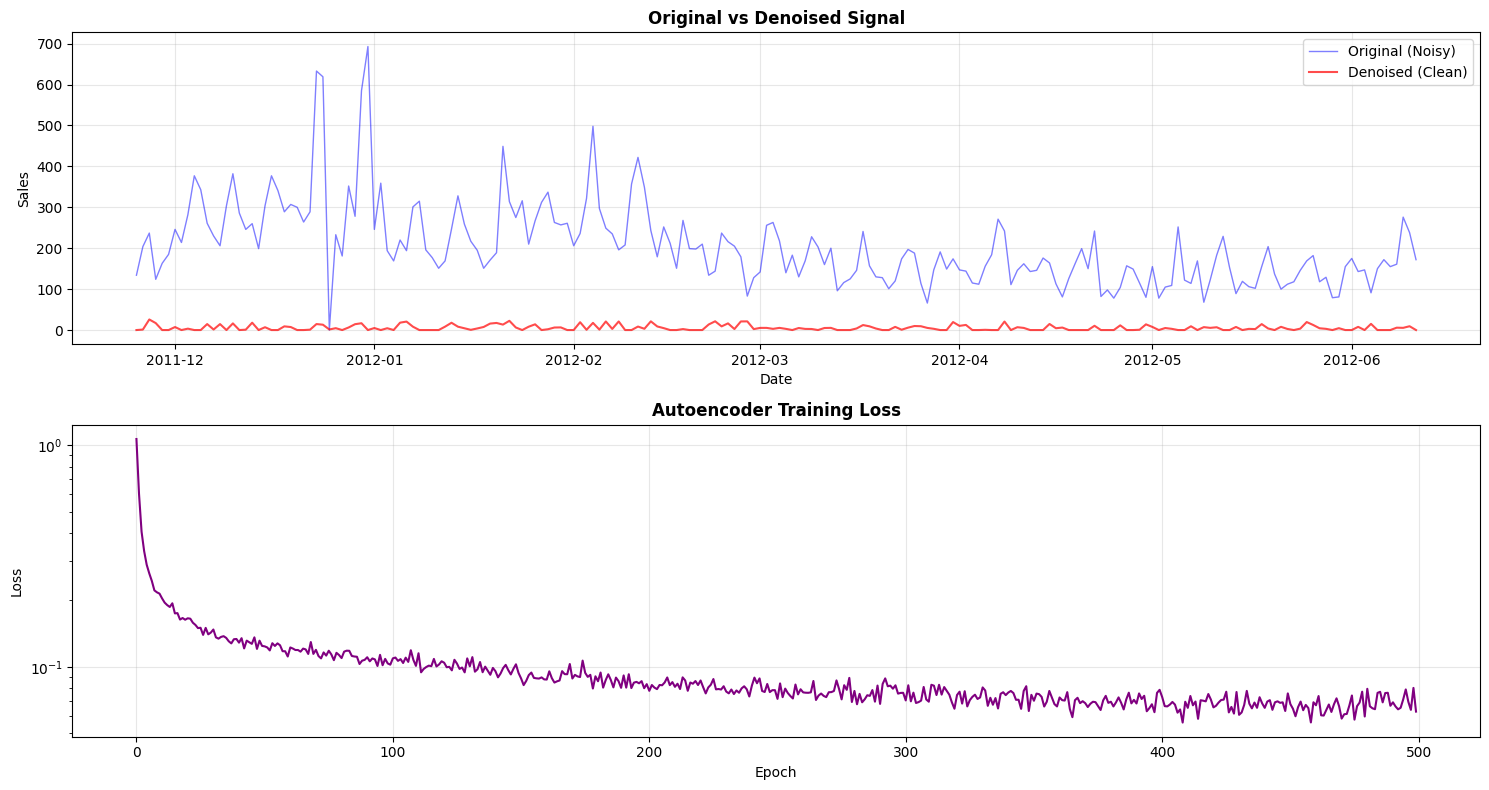


🤖 ENGLISH: Defining LSTM Forecaster (Simplified)...
🤖 ESPAÑOL: Definiendo LSTM para forecasting (Simplificado)...

🔧 ENGLISH: Creating sequences with clean data...
🔧 ESPAÑOL: Creando secuencias con datos limpios...
✅ Clean sequences for training: X (445, 21, 5), y_clean (445,)
✅ Original values for evaluation: y_original (445,)

✂️ Train/Test split:
   Train: 356 sequences
   Test:  89 sequences

🎯 ENGLISH: Training LSTM with clean data...
🎯 ESPAÑOL: Entrenando LSTM con datos limpios...
   Epoch 40/200, Train Loss: 0.017948, Val Loss: 2.544437, LR: 0.0100
   Epoch 80/200, Train Loss: 0.000004, Val Loss: 2.514092, LR: 0.0050
   Epoch 120/200, Train Loss: 0.000000, Val Loss: 2.516130, LR: 0.0025
   Epoch 160/200, Train Loss: 0.000000, Val Loss: 2.516162, LR: 0.0013
   Epoch 200/200, Train Loss: 0.000000, Val Loss: 2.516170, LR: 0.0006

✅ LSTM trained successfully!
   Best validation loss: 0.871789

📊 ENGLISH: Generating predictions and evaluating on ORIGINAL scale...
📊 ESPAÑOL: Generand

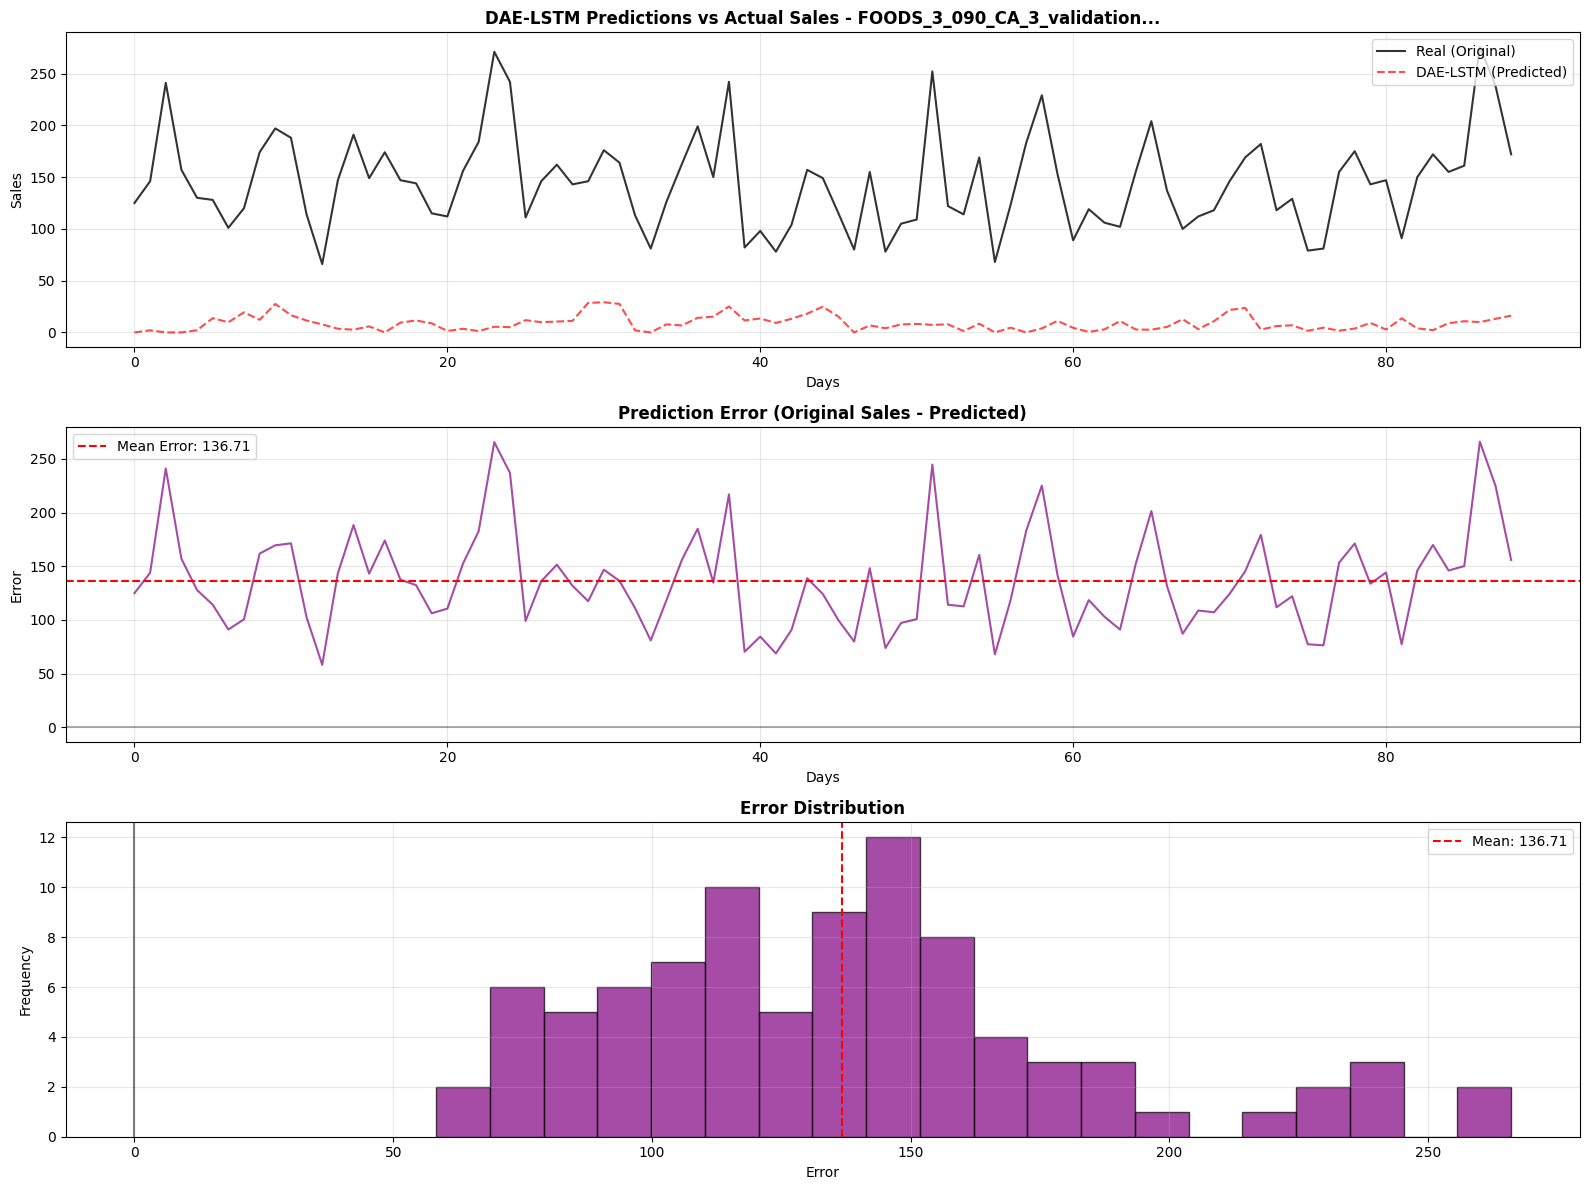


💾 Saving corrected results...
✅ Corrected results saved: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\resultados\16_dae_lstm_results_V2.csv
✅ Copy saved: 16_dae_lstm_results_V2.csv

🔍 VERIFICATION - SCALE CHECK:

📊 SCALE VERIFICATION / VERIFICACIÓN DE ESCALA:
────────────────────────────────────────────
Original sales - mean: 117.26
Original sales - std:  132.15
Original sales - min:  0.00
Original sales - max:  693.00

DAE-LSTM V2 predictions - mean: 8.74
DAE-LSTM V2 predictions - std:  7.27
DAE-LSTM V2 predictions - min:  0.00
DAE-LSTM V2 predictions - max:  29.17

✅ NOTEBOOK 16 VERSIÓN 2.0 COMPLETADO
✅ ARQUITECTURA SIMPLIFICADA Y OPTIMIZADA


In [1]:
# ============================================================
# NOTEBOOK 16: Denoising Autoencoder + LSTM - VERSIÓN 2.0 SIMPLIFICADA
# ============================================================
# ENGLISH: Clean noise from data before forecasting
# ESPAÑOL: Limpia el ruido de los datos antes de predecir
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import os
import glob
warnings.filterwarnings('ignore')

# ============================================================
# CONFIGURATION / CONFIGURACIÓN
# ============================================================
print("="*60)
print("🔧 CONFIGURATION / CONFIGURACIÓN")
print("="*60)

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.dirname(NOTEBOOK_DIR)

FIGURES_DIR = os.path.join(NOTEBOOK_DIR, "figures")
RESULTS_DIR = os.path.join(NOTEBOOK_DIR, "resultados")

os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"✅ ENGLISH: Current directory / Directorio actual: {NOTEBOOK_DIR}")
print(f"✅ ENGLISH: Figures will be saved in / Figuras se guardarán en: {FIGURES_DIR}")
print(f"✅ ESPAÑOL: Resultados se guardarán en / Results will be saved in: {RESULTS_DIR}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ ENGLISH: Using device / Usando dispositivo: {device}")
print("="*60)

# ============================================================
# LOAD DATASET / CARGAR DATASET
# ============================================================
print("\n📂 ENGLISH: Loading M5 dataset...")
print("📂 ESPAÑOL: Cargando dataset M5...")

def find_dataset():
    locations = [
        "data/m5_top3_multivariate.csv",
        "data/processed/m5_top3_multivariate.csv",
        "../data/processed/m5_top3_multivariate.csv",
        "m5_top3_multivariate.csv",
        os.path.join(PROJECT_ROOT, "data", "processed", "m5_top3_multivariate.csv"),
        os.path.join(NOTEBOOK_DIR, "data", "m5_top3_multivariate.csv"),
    ]
    
    for path in locations:
        if os.path.exists(path):
            return path
    
    files = glob.glob("**/m5_top3*.csv", recursive=True)
    if files:
        return files[0]
    
    return None

dataset_path = find_dataset()
print(f"✅ ENGLISH: Dataset found / Dataset encontrado: {dataset_path}")

df = pd.read_csv(dataset_path)
df['date'] = pd.to_datetime(df['date'])
print(f"✅ ENGLISH: Dataset shape / Dimensiones: {df.shape}")
print(f"✅ ESPAÑOL: Productos / Products: {df['id'].unique().tolist()}")

# ============================================================
# SELECT TOP PRODUCT / SELECCIONAR PRODUCTO TOP
# ============================================================
print("\n🎯 ENGLISH: Selecting top product...")
print("🎯 ESPAÑOL: Seleccionando producto top...")

product_sales = df.groupby('id')['sales'].sum().sort_values(ascending=False)
product_id = product_sales.index[0]
df_product = df[df['id'] == product_id].sort_values('date').copy()

print(f"✅ ENGLISH: Product selected / Producto seleccionado: {product_id}")
print(f"✅ ESPAÑOL: Total sales / Ventas totales: {product_sales[product_id]:,.0f}")
print(f"✅ Records / Registros: {len(df_product)}")
print(f"✅ Date range / Rango de fechas: {df_product['date'].min()} → {df_product['date'].max()}")

# ============================================================
# VISUALIZE ORIGINAL SERIES
# ============================================================
print("\n🎨 ENGLISH: Visualizing original series...")
print("🎨 ESPAÑOL: Visualizando serie original...")

plt.figure(figsize=(15, 5))
plt.plot(df_product['date'], df_product['sales'], color='blue', alpha=0.7, linewidth=1.5)
plt.title(f'ENGLISH: Original Sales Series - ESPAÑOL: Serie Original de Ventas\n{product_id[:50]}...', 
          fontsize=12, fontweight='bold')
plt.xlabel('Date / Fecha')
plt.ylabel('Sales / Ventas')
plt.grid(True, alpha=0.3)

plot_path = os.path.join(FIGURES_DIR, f"16_original_series_{product_id[:10]}.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✅ ENGLISH: Plot saved / Gráfica guardada: {plot_path}")
plt.savefig(f"16_original_series_{product_id[:10]}.png", dpi=150, bbox_inches='tight')
print(f"✅ ESPAÑOL: Copia guardada / Copy saved: 16_original_series_{product_id[:10]}.png")
plt.show()

# ============================================================
# DENOISING AUTOENCODER DEFINITION - VERSIÓN MEJORADA
# ============================================================
print("\n🧹 ENGLISH: Defining Denoising Autoencoder (Improved)...")
print("🧹 ESPAÑOL: Definiendo Autoencoder Denoising (Mejorado)...")

class DenoisingAutoencoder(nn.Module):
    """
    ENGLISH: Autoencoder that learns to clean noisy signals
    ESPAÑOL: Autoencoder que aprende a limpiar señales ruidosas
    """
    
    def __init__(self, input_dim, encoding_dim=32):  # Aumentado de 16 a 32
        super(DenoisingAutoencoder, self).__init__()
        
        # ENGLISH: Encoder - compresses the signal
        # ESPAÑOL: Encoder - comprime la señal
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),  # Más ancho
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        
        # ENGLISH: Decoder - reconstructs clean signal
        # ESPAÑOL: Decoder - reconstruye la señal limpia
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded
    
    def add_noise(self, x, noise_factor=0.1):
        """
        ENGLISH: Add Gaussian noise for denoising training
        ESPAÑOL: Añadir ruido gaussiano para entrenamiento denoising
        """
        noise = torch.randn_like(x) * noise_factor
        return x + noise

# ============================================================
# CREATE WINDOWS FOR AUTOENCODER
# ============================================================
print("\n🔧 ENGLISH: Creating windows for Autoencoder...")
print("🔧 ESPAÑOL: Creando ventanas para Autoencoder...")

window_size = 21  # Aumentado de 14 a 21 días
feature_cols = ['sales', 'sell_price', 'snap', 'dayofweek', 'is_weekend']

def create_windows(data, window_size, feature_cols):
    windows = []
    dates = []
    for i in range(len(data) - window_size + 1):
        window = data[feature_cols].iloc[i:i+window_size].values.flatten()
        windows.append(window)
        dates.append(data['date'].iloc[i + window_size - 1])
    return np.array(windows), np.array(dates)

windows, window_dates = create_windows(df_product, window_size, feature_cols)
print(f"✅ ENGLISH: Windows created / Ventanas creadas: {windows.shape}")

scaler_ae = StandardScaler()
windows_scaled = scaler_ae.fit_transform(windows)
windows_tensor = torch.FloatTensor(windows_scaled).to(device)

# ============================================================
# TRAIN DENOISING AUTOENCODER - MÁS ÉPOCAS
# ============================================================
print("\n🧠 ENGLISH: Training Denoising Autoencoder (500 epochs)...")
print("🧠 ESPAÑOL: Entrenando Autoencoder Denoising (500 épocas)...")

input_dim = windows.shape[1]
encoding_dim = 32
dae = DenoisingAutoencoder(input_dim, encoding_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(dae.parameters(), lr=0.001)

epochs = 500  # Aumentado de 200 a 500
batch_size = 32
train_losses = []

dataset = TensorDataset(windows_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    epoch_loss = 0
    for batch in loader:
        batch_windows = batch[0]
        noisy_windows = dae.add_noise(batch_windows, noise_factor=0.1)
        reconstructed, _ = dae(noisy_windows)
        loss = criterion(reconstructed, batch_windows)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(dae.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 100 == 0:
        print(f"   Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

print(f"\n✅ ENGLISH: Denoising Autoencoder trained successfully!")
print(f"✅ ESPAÑOL: Autoencoder Denoising entrenado exitosamente!")
print(f"   Final loss / Loss final: {train_losses[-1]:.6f}")

# ============================================================
# CREATE CLEAN DATASET
# ============================================================
print("\n🎨 ENGLISH: Creating clean dataset...")
print("🎨 ESPAÑOL: Creando dataset limpio...")

dae.eval()
with torch.no_grad():
    reconstructed_windows, encoded_features = dae(windows_tensor)
    reconstructed = reconstructed_windows.cpu().numpy()
    encoded = encoded_features.cpu().numpy()

reconstructed_descaled = scaler_ae.inverse_transform(reconstructed)

df_clean = df_product.iloc[window_size-1:].copy()
df_clean = df_clean.reset_index(drop=True)

for i, col in enumerate(feature_cols):
    df_clean[f'{col}_clean'] = reconstructed_descaled[:, i::len(feature_cols)].flatten()[:len(df_clean)]

df_clean['sales_clean'] = df_clean['sales_clean'].clip(lower=0)
df_clean['sales_original'] = df_product['sales'].iloc[window_size-1:].values

# Visualize reconstruction
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(df_product['date'].iloc[-200:], df_product['sales'].iloc[-200:], 
         label='Original (Noisy)', color='blue', alpha=0.5, linewidth=1)
plt.plot(df_clean['date'].iloc[-200:], df_clean['sales_clean'].iloc[-200:], 
         label='Denoised (Clean)', color='red', alpha=0.7, linewidth=1.5)
plt.title('Original vs Denoised Signal', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(train_losses, color='purple', linewidth=1.5)
plt.title('Autoencoder Training Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()

plot_path = os.path.join(FIGURES_DIR, f"16_autoencoder_reconstruction_{product_id[:10]}.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✅ Reconstruction plot saved: {plot_path}")
plt.savefig(f"16_autoencoder_reconstruction_{product_id[:10]}.png", dpi=150, bbox_inches='tight')
print(f"✅ Copy saved: 16_autoencoder_reconstruction_{product_id[:10]}.png")
plt.show()

# ============================================================
# LSTM FORECASTER DEFINITION - VERSIÓN SIMPLIFICADA
# ============================================================
print("\n🤖 ENGLISH: Defining LSTM Forecaster (Simplified)...")
print("🤖 ESPAÑOL: Definiendo LSTM para forecasting (Simplificado)...")

class LSTMForecaster(nn.Module):
    """
    ENGLISH: Simplified LSTM model for time series forecasting
    ESPAÑOL: Modelo LSTM simplificado para forecasting de series temporales
    """
    
    def __init__(self, input_dim, hidden_dim=32, num_layers=1, output_dim=1):
        super(LSTMForecaster, self).__init__()
        
        # 🟢 SIMPLIFICADO: Unidireccional, 1 capa
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True,
            bidirectional=False  # ¡CRÍTICO! Unidireccional para series temporales
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ============================================================
# CREATE SEQUENCES WITH CLEAN DATA
# ============================================================
print("\n🔧 ENGLISH: Creating sequences with clean data...")
print("🔧 ESPAÑOL: Creando secuencias con datos limpios...")

clean_features = [f'{col}_clean' for col in feature_cols]
seq_length = 21  # Aumentado de 14 a 21

def create_sequences(data, target_col, feature_cols, seq_length):
    features = data[feature_cols].values
    target = data[target_col].values
    
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(target[i + seq_length])
    
    return np.array(X), np.array(y)

# Crear secuencias para entrenamiento (clean) y evaluación (original)
X_clean, y_clean = create_sequences(df_clean, 'sales_clean', clean_features, seq_length)
_, y_original = create_sequences(df_clean, 'sales_original', clean_features, seq_length)

print(f"✅ Clean sequences for training: X {X_clean.shape}, y_clean {y_clean.shape}")
print(f"✅ Original values for evaluation: y_original {y_original.shape}")

# ============================================================
# SCALE AND SPLIT DATA
# ============================================================
# Scale features
X_shape = X_clean.shape
X_reshaped = X_clean.reshape(-1, X_shape[-1])
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_reshaped).reshape(X_shape)

# Scale target
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_clean.reshape(-1, 1)).flatten()

# Train/test split
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Guardar valores originales para evaluación
y_original_train = y_original[:train_size]
y_original_test = y_original[train_size:]

print(f"\n✂️ Train/Test split:")
print(f"   Train: {X_train.shape[0]} sequences")
print(f"   Test:  {X_test.shape[0]} sequences")

# Convert to tensors
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.FloatTensor(y_train).to(device).view(-1, 1)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.FloatTensor(y_test).to(device).view(-1, 1)

# ============================================================
# TRAIN LSTM WITH CLEAN DATA - VERSIÓN SIMPLIFICADA
# ============================================================
print("\n🎯 ENGLISH: Training LSTM with clean data...")
print("🎯 ESPAÑOL: Entrenando LSTM con datos limpios...")

lstm_model = LSTMForecaster(
    input_dim=len(clean_features),
    hidden_dim=32,  # Reducido de 64 a 32
    num_layers=1,   # Reducido de 2 a 1
    output_dim=1
).to(device)

criterion = nn.MSELoss()
# 🟢 LEARNING RATE MÁS ALTO
optimizer = optim.Adam(lstm_model.parameters(), lr=0.01)  # De 0.001 a 0.01
# 🟢 STEP LR SCHEDULER (más simple)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

epochs = 200  # Aumentado de 100 a 200
batch_size = 16
train_losses_lstm = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    # Training
    lstm_model.train()
    permutation = torch.randperm(X_train_t.size(0))
    epoch_loss = 0
    
    for i in range(0, X_train_t.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train_t[indices], y_train_t[indices]
        
        optimizer.zero_grad()
        output = lstm_model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / (X_train_t.size(0) / batch_size)
    train_losses_lstm.append(avg_train_loss)
    
    # Validation
    lstm_model.eval()
    with torch.no_grad():
        val_pred = lstm_model(X_test_t)
        val_loss = criterion(val_pred, y_test_t)
        val_losses.append(val_loss.item())
    
    scheduler.step()
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(lstm_model.state_dict(), os.path.join(RESULTS_DIR, "16_best_lstm_clean.pth"))
    
    if (epoch + 1) % 40 == 0:
        print(f"   Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.4f}")

print(f"\n✅ LSTM trained successfully!")
print(f"   Best validation loss: {best_val_loss:.6f}")

# ============================================================
# PREDICTIONS AND EVALUATION
# ============================================================
print("\n📊 ENGLISH: Generating predictions and evaluating on ORIGINAL scale...")
print("📊 ESPAÑOL: Generando predicciones y evaluando en escala ORIGINAL...")

lstm_model.eval()
with torch.no_grad():
    y_pred_train_scaled = lstm_model(X_train_t)
    y_pred_test_scaled = lstm_model(X_test_t)

# Inverse scaling
y_pred_train_clean = scaler_y.inverse_transform(y_pred_train_scaled.cpu().numpy())
y_pred_test_clean = scaler_y.inverse_transform(y_pred_test_scaled.cpu().numpy())

# Evaluar contra valores originales
y_pred_train = y_pred_train_clean
y_pred_test = y_pred_test_clean
y_train_actual = y_original_train
y_test_actual = y_original_test

# No negative predictions
y_pred_train = np.maximum(y_pred_train, 0)
y_pred_test = np.maximum(y_pred_test, 0)

# ============================================================
# EVALUATION METRICS
# ============================================================
def evaluate_forecast(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    mask = y_true > 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    bias = np.mean(y_pred - y_true)
    
    print(f"\n📈 {name}:")
    print(f"   MAE:  {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   Bias: {bias:.2f}")
    
    return {'mae': mae, 'rmse': rmse, 'mape': mape, 'bias': bias}

print("\n" + "="*60)
print("📊 DAE-LSTM EVALUATION ON ORIGINAL SALES")
print("="*60)

metrics_train = evaluate_forecast(y_train_actual, y_pred_train, "TRAIN")
metrics_test = evaluate_forecast(y_test_actual, y_pred_test, "TEST")

# ============================================================
# VISUALIZATION
# ============================================================
print("\n🎨 Generating visualizations with ORIGINAL sales...")

plt.figure(figsize=(16, 12))

# Plot 1: DAE-LSTM Predictions vs REAL sales
plt.subplot(3, 1, 1)
plt.plot(y_test_actual, label='Real (Original)', color='black', linewidth=1.5, alpha=0.8)
plt.plot(y_pred_test, label='DAE-LSTM (Predicted)', color='red', linewidth=1.5, alpha=0.7, linestyle='--')
plt.title(f'DAE-LSTM Predictions vs Actual Sales - {product_id[:50]}...', fontsize=12, fontweight='bold')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Prediction Error
plt.subplot(3, 1, 2)
error = y_test_actual.flatten() - y_pred_test.flatten()
plt.plot(error, color='purple', alpha=0.7, linewidth=1.5)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=np.mean(error), color='red', linestyle='--', 
            label=f'Mean Error: {np.mean(error):.2f}')
plt.title('Prediction Error (Original Sales - Predicted)', fontsize=12, fontweight='bold')
plt.xlabel('Days')
plt.ylabel('Error')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Error Distribution
plt.subplot(3, 1, 3)
plt.hist(error, bins=20, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.axvline(x=np.mean(error), color='red', linestyle='--', 
            label=f'Mean: {np.mean(error):.2f}')
plt.title('Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

plot_path = os.path.join(FIGURES_DIR, f"16_dae_lstm_predictions_{product_id[:10]}.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✅ Predictions plot saved: {plot_path}")
plt.savefig(f"16_dae_lstm_predictions_{product_id[:10]}.png", dpi=150, bbox_inches='tight')
print(f"✅ Copy saved: 16_dae_lstm_predictions_{product_id[:10]}.png")
plt.show()

# ============================================================
# SAVE RESULTS
# ============================================================
print("\n" + "="*60)
print("💾 Saving corrected results...")
print("="*60)

results = pd.DataFrame({
    'model': ['DenoisingAutoencoder_LSTM_V2'],
    'product_id': [product_id],
    'execution_date': [pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')],
    'window_size': [window_size],
    'encoding_dim': [encoding_dim],
    'seq_length': [seq_length],
    'ae_loss': [train_losses[-1]],
    'mae_train': [metrics_train['mae']],
    'rmse_train': [metrics_train['rmse']],
    'mape_train': [metrics_train['mape']],
    'mae_test': [metrics_test['mae']],
    'rmse_test': [metrics_test['rmse']],
    'mape_test': [metrics_test['mape']],
    'bias': [metrics_test['bias']],
    'features': [str(clean_features)],
    'target': ['sales_original']
})

results_path = os.path.join(RESULTS_DIR, "16_dae_lstm_results_V2.csv")
results.to_csv(results_path, index=False)
print(f"✅ Corrected results saved: {results_path}")
results.to_csv("16_dae_lstm_results_V2.csv", index=False)
print(f"✅ Copy saved: 16_dae_lstm_results_V2.csv")

# ============================================================
# VERIFICATION
# ============================================================
print("\n🔍 VERIFICATION - SCALE CHECK:")
print("="*60)

print(f"""
📊 SCALE VERIFICATION / VERIFICACIÓN DE ESCALA:
────────────────────────────────────────────
Original sales - mean: {df_product['sales'].mean():.2f}
Original sales - std:  {df_product['sales'].std():.2f}
Original sales - min:  {df_product['sales'].min():.2f}
Original sales - max:  {df_product['sales'].max():.2f}

DAE-LSTM V2 predictions - mean: {y_pred_test.mean():.2f}
DAE-LSTM V2 predictions - std:  {y_pred_test.std():.2f}
DAE-LSTM V2 predictions - min:  {y_pred_test.min():.2f}
DAE-LSTM V2 predictions - max:  {y_pred_test.max():.2f}
""")

print("="*60)
print("✅ NOTEBOOK 16 VERSIÓN 2.0 COMPLETADO")
print("✅ ARQUITECTURA SIMPLIFICADA Y OPTIMIZADA")
print("="*60)